# TFG - Comprendiendo la depresión a traves de XAI
Tamara Pérez Pérez



## Table of contents<a class="anchor" id="index"></a>

[Modeling Data: Labs and Examination Dataset](#modeling-data)
* [Imports](#imports)
* [Demographic Dataset](#dataset)
   * [Decision Tree Classifier](#dtree)
   * [Explainable Boosting Classifier](#ebm)
   * [Random Forest](#rf)
       * [SHAP](#shap)
       * [LIME](#lime)

## Modeling Data: Labs and Examination Dataset<a class="anchor" id="modeling-data"></a>

### Imports<a class="anchor" id="imports"></a>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from interpret.glassbox import (LogisticRegression,
                                ClassificationTree,
                                ExplainableBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from interpret.blackbox import LimeTabular
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss, TomekLinks
from imblearn.combine import SMOTETomek
from interpret import show
import shap
%matplotlib inline
%run functions.ipynb

Read the CSV file into a DataFrame and select relevant features for analysis.  
Preprocess binary responses, perform one-hot encoding on object columns, and display the head of the resulting DataFrame.

In [10]:
df = pd.read_csv('../csv/df.csv',index_col=0)
features = ['HDL-cholesterol',
             'LDL-cholesterol',
             'triglyceride',
             'lymphocyte_percent',
             'monocyte_percent',
             'neutrophils_percent',
             'eosinophils_percent',
             'basophils_percent',
             'hematocrit_percent',
             'vitamin_B12',
             'albumin',
             'AST',
             'ALT',
             'blood_urea_nitrogen',
             'bicarbonate',
             'total_calcium',
             'CPK',
             'chloride',
             'creatinine',
             'globulin',
             'glucose',
             'gamma_glutamyl_transferase',
             'iron',
             'potassium',
             'lactate_dehydrogenase',
             'sodium',
             'osmolality',
             'phosphorus',
             'total_bilirubin',
             'total_protein',
             'uric_acid',
             'pulse',
             'systolic_blood_pressure',
             'diastoli_blood_pressure',
             'BMI',
            'depression_status']
df_labs_exam = select_features(df, features)
df_labs_exam = preprocess_binary_responses(df_labs_exam)
df_labs_exam = one_hot_encode_object_columns(df_labs_exam)
df_labs_exam.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5372 entries, 73557 to 83727
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   HDL-cholesterol             5372 non-null   float64
 1   LDL-cholesterol             5372 non-null   float64
 2   triglyceride                5372 non-null   float64
 3   lymphocyte_percent          5372 non-null   float64
 4   monocyte_percent            5372 non-null   float64
 5   neutrophils_percent         5372 non-null   float64
 6   eosinophils_percent         5372 non-null   float64
 7   basophils_percent           5372 non-null   float64
 8   hematocrit_percent          5372 non-null   float64
 9   vitamin_B12                 5372 non-null   float64
 10  albumin                     5372 non-null   float64
 11  AST                         5372 non-null   float64
 12  ALT                         5372 non-null   float64
 13  blood_urea_nitrogen         

,HDL-cholesterol,LDL-cholesterol,triglyceride,lymphocyte_percent,monocyte_percent,neutrophils_percent,eosinophils_percent,basophils_percent,hematocrit_percent,vitamin_B12,...,osmolality,phosphorus,total_bilirubin,total_protein,uric_acid,pulse,systolic_blood_pressure,diastoli_blood_pressure,BMI,depression_status
SEQN,,,,,,,,,,,,,,,,,,,,,
73557,65.0,49.586843,49.505354,42.2,11.0,42.3,3.4,1.2,45.4,524.0,...,296.0,4.3,0.8,6.5,3.3,86.0,122.0,72.0,26.7,0
73558,50.0,49.586843,49.505354,27.3,7.6,58.4,6.1,0.6,36.7,507.0,...,265.0,3.9,0.9,7.8,4.7,74.0,156.0,62.0,28.6,0
73559,60.0,56.000000,51.000000,13.9,11.5,68.2,5.6,0.9,49.9,732.0,...,288.0,4.2,0.6,5.9,5.7,68.0,140.0,90.0,28.9,0
73561,85.0,101.000000,75.000000,20.5,6.9,68.7,2.4,1.4,43.8,225.0,...,290.0,4.4,0.5,7.1,4.2,92.0,136.0,86.0,19.7,0
73562,38.0,49.586843,49.505354,17.4,6.6,69.2,5.9,0.9,41.5,750.0,...,287.0,3.3,0.5,7.3,9.1,60.0,160.0,84.0,41.7,1


Split the dataset into training and testing sets using an 80-20 split

In [12]:
X_train, X_test, y_train, y_test = split_data(df_labs_exam, target_column='depression_status', test_size=0.2, random_state=42)

### Decision Tree Classifier<a class="anchor" id="dtree"></a>

Train a Decision Tree classifier and evaluating its performance

____________________________________________________________

CLASSIFICATION REPORT FOR: DECISION TREE CLASSIFIER
____________________________________________________________
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       974
           1       1.00      0.00      0.00       101

    accuracy                           0.91      1075
   macro avg       0.95      0.50      0.48      1075
weighted avg       0.91      0.91      0.86      1075

AUC-PR: 0.91


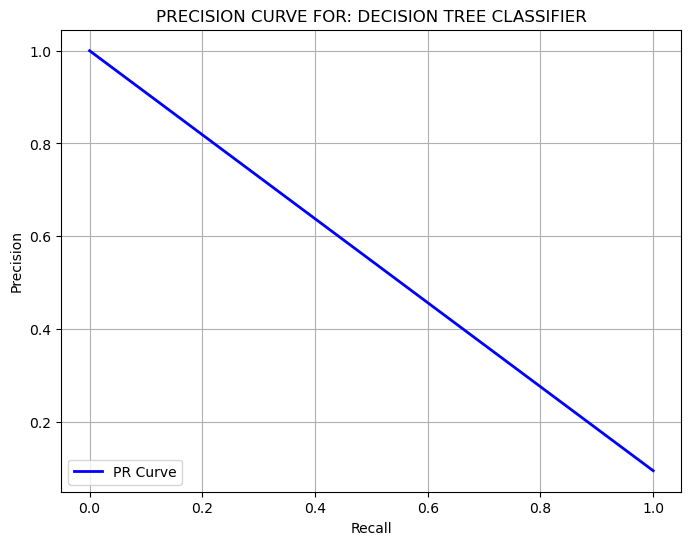

In [13]:
dt = ClassificationTree(random_state=42)
dt.fit(X_train, y_train)
analyze_results(dt, X_train, X_test, y_test, title='DECISION TREE CLASSIFIER')

The results for class 1 (depression) are unsatisfactory. We will attempt oversampling to balance the data.

In [14]:
X_train_over, y_train_over = oversample_data(X_train, y_train, strategy='auto')

Before oversampling: [(0, 3887), (1, 410)]
After oversampling: [(0, 3887), (1, 3887)]


Train a new Decision Tree classifier and evaluate its performance

____________________________________________________________

CLASSIFICATION REPORT FOR: DECISION TREE CLASSIFIER
____________________________________________________________
              precision    recall  f1-score   support

           0       0.91      0.52      0.66       974
           1       0.10      0.50      0.16       101

    accuracy                           0.52      1075
   macro avg       0.50      0.51      0.41      1075
weighted avg       0.83      0.52      0.61      1075

AUC-PR: 0.52


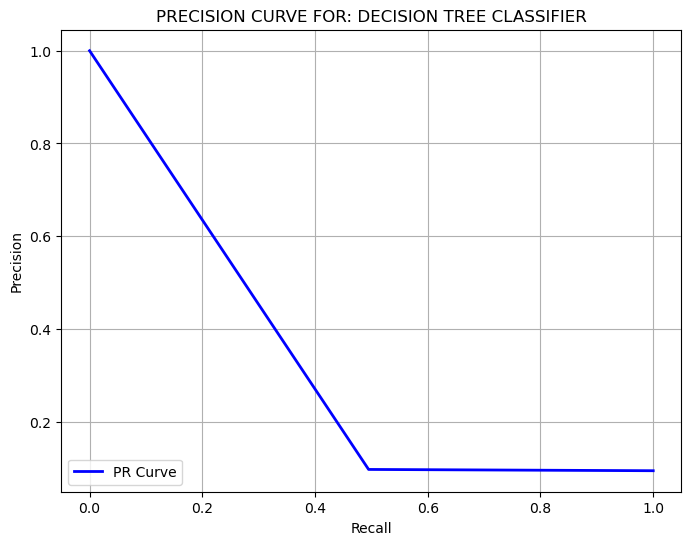

In [16]:
dt2 = ClassificationTree(random_state=42)
dt2.fit(X_train_over, y_train_over)
analyze_results(dt2, X_train_over, X_test, y_test, title='DECISION TREE CLASSIFIER')

Despite a slight improvement in performance, the results are not still optimal.  
To gain insights and explanations, we will utilize the InterpretML package to get global and local explanations.

In [17]:
# Explain the global model
dt_global = dt2.explain_global(name="Classification Tree")
show(dt_global)

# Explain the local model
dt_local = dt2.explain_local(X_test, y_test, name="Classification Tree")
show(dt_local)

<!-- http://127.0.0.1:7982/1942301595392/ -->

<!-- http://127.0.0.1:7982/1942560302848/ -->

### Explainable Boosting Classifier<a class="anchor" id="ebm"></a>

Train an Explainable Boosting classifier and evaluate its performance

____________________________________________________________

CLASSIFICATION REPORT FOR: EXPLAINABLE BOOSTING CLASSIFIER
____________________________________________________________
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       974
           1       0.19      0.22      0.21       101

    accuracy                           0.84      1075
   macro avg       0.56      0.56      0.56      1075
weighted avg       0.85      0.84      0.85      1075

AUC-PR: 0.84


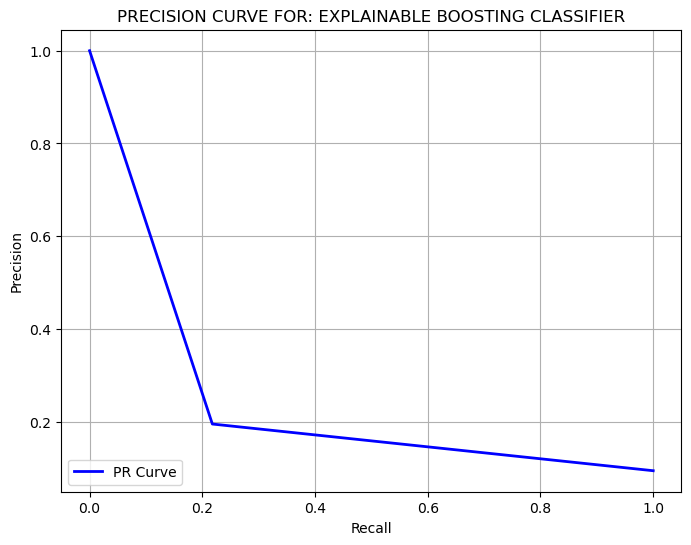

In [18]:
ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(X_train_over, y_train_over)
analyze_results(ebm, X_train_over, X_test, y_test, title='EXPLAINABLE BOOSTING CLASSIFIER')

Obtain global and local explanations using the InterpretML package

In [19]:
# Explain the global model
ebm_global = ebm.explain_global(name="EBM")
show(ebm_global)

# Explain the local model
ebm_local = ebm.explain_local(X_test, y_test)
show(ebm_local)

<!-- http://127.0.0.1:7982/1942580932368/ -->

<!-- http://127.0.0.1:7982/1942582584752/ -->

### Random Forest<a class="anchor" id="rf"></a>

Create a RandomForestClassifier with balanced class weights, train the model on the training data, and analyze the results.

____________________________________________________________

CLASSIFICATION REPORT FOR: 
____________________________________________________________
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       974
           1       0.00      0.00      0.00       101

    accuracy                           0.91      1075
   macro avg       0.45      0.50      0.48      1075
weighted avg       0.82      0.91      0.86      1075

AUC-PR: 0.91


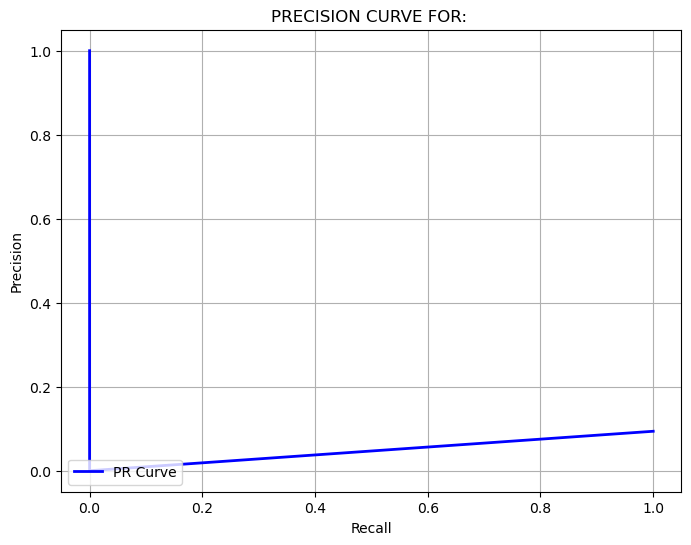

In [4]:
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_clf.fit(X_train, y_train)
analyze_results(rf_clf, X_train, X_test, y_test)

The results are terrible for class 1. We will try to find best parameters using GridSearchCV

In [5]:
best_params_rf = {'criterion': ['gini', 'entropy'],
                  'max_depth': [3,4,5,6], 
                  'min_samples_split': [25,30,35],
                  'class_weight': ['balanced', 'balanced_subsample'], 
                  'n_estimators': [100,200,300]}

grid = GridSearchCV(rf_clf, best_params_rf, cv=5, scoring='accuracy')
rf_grid = grid.fit(X_train, y_train)

In [20]:
rf_grid.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 6,
 'min_samples_split': 25,
 'n_estimators': 300}

____________________________________________________________

CLASSIFICATION REPORT FOR: 
____________________________________________________________
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       974
           1       0.28      0.23      0.25       101

    accuracy                           0.87      1075
   macro avg       0.60      0.58      0.59      1075
weighted avg       0.86      0.87      0.87      1075

AUC-PR: 0.87


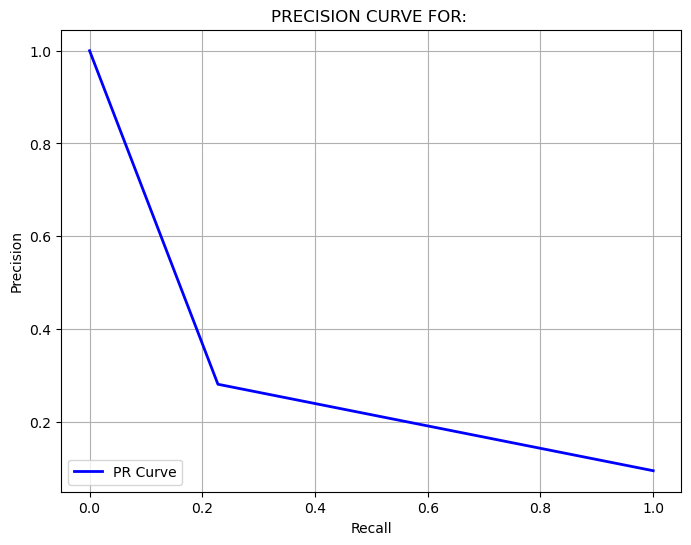

In [22]:
rf_grid = rf_grid.best_estimator_
analyze_results(rf_grid, X_train, X_test, y_test)

____________________________________________________________

CLASSIFICATION REPORT FOR: 
____________________________________________________________
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       974
           1       0.27      0.23      0.25       101

    accuracy                           0.87      1075
   macro avg       0.60      0.58      0.59      1075
weighted avg       0.86      0.87      0.87      1075

AUC-PR: 0.87


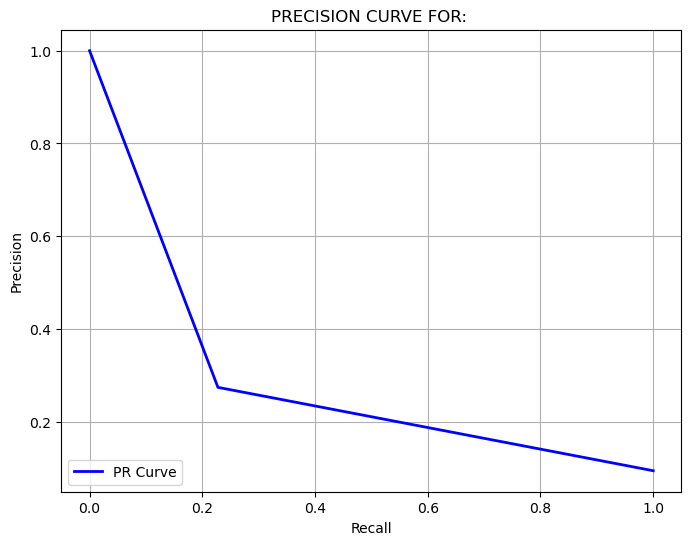

In [8]:
# rf_clf = RandomForestClassifier(n_estimators=300, class_weight='balanced_subsample',
#                                 max_depth=6, min_samples_split=25,random_state=42)
# rf_clf.fit(X_train, y_train)
# analyze_results(rf_clf, X_train, X_test, y_test)

We increased the performance, even though is still not good. We will use SHAP and LIME to get some explanations locally and globally

### SHAP<a class="anchor" id="shap"></a>

Obtain global explanations for the first 20 instances using SHAP

Prediction: 0


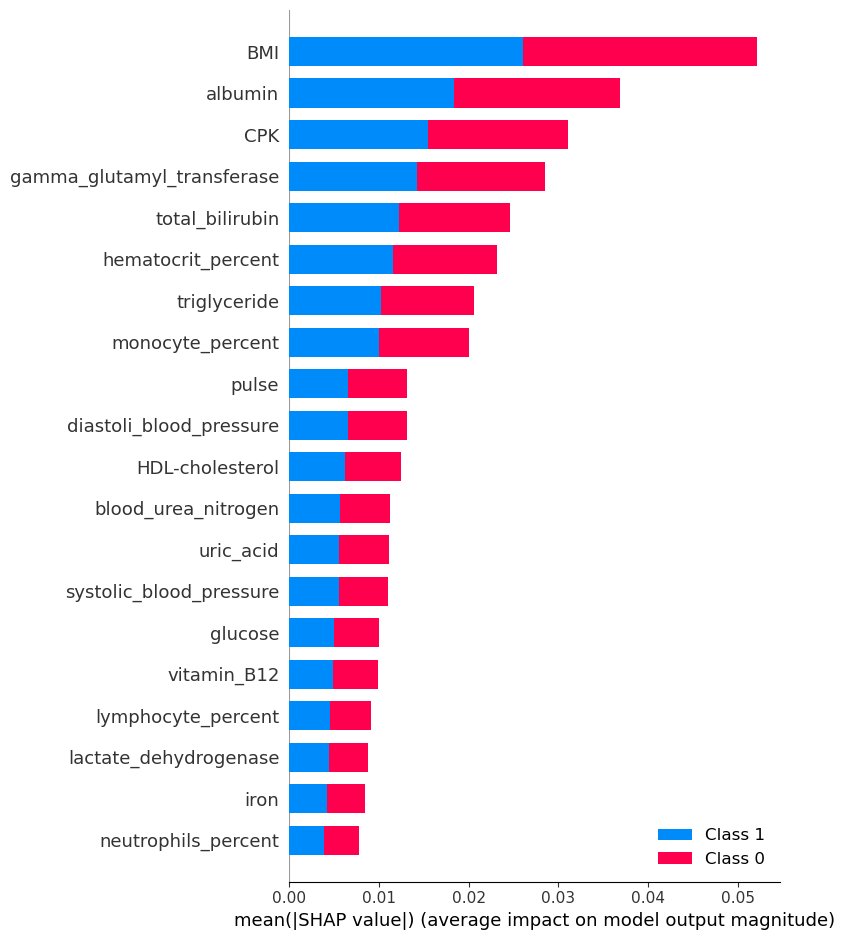

None

In [23]:
shap.initjs()
shap_explanation(rf_grid, X_test, start_index=0, end_index=20)

Obtain  explanations for instance 2 (Not Depressed)

Prediction: 0


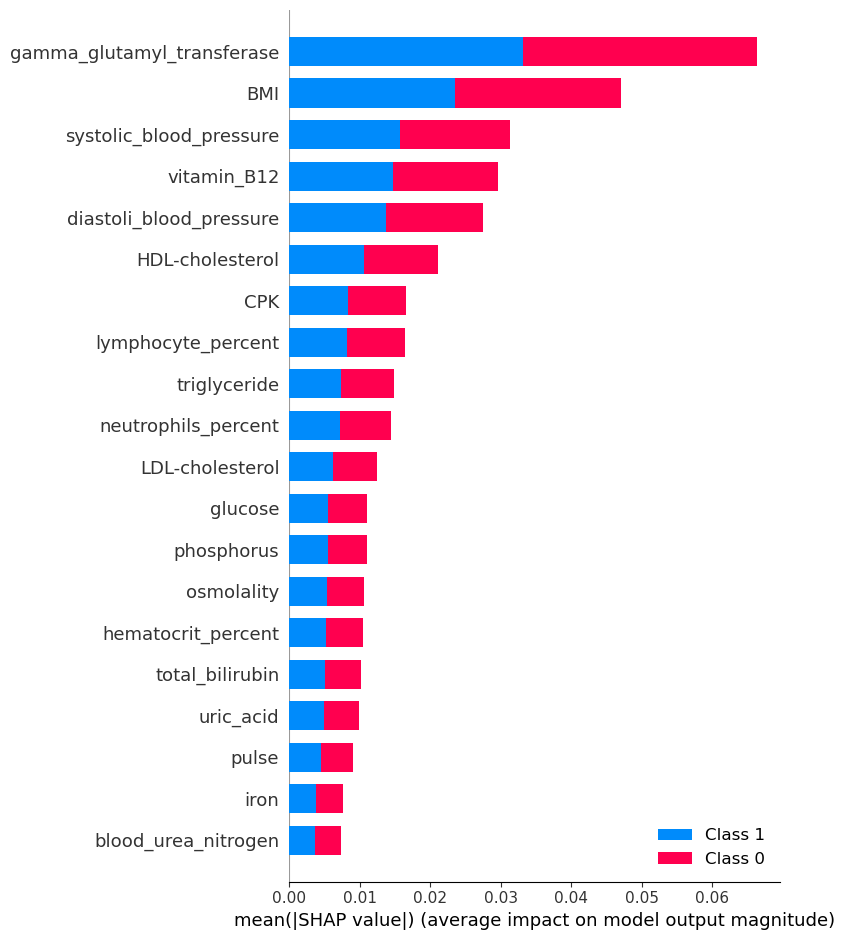

None

In [24]:
shap.initjs()
shap_explanation(rf_grid, X_test, start_index=2, end_index=3)

Obtain  explanations for instance 108 (Depressed)

Prediction: 1


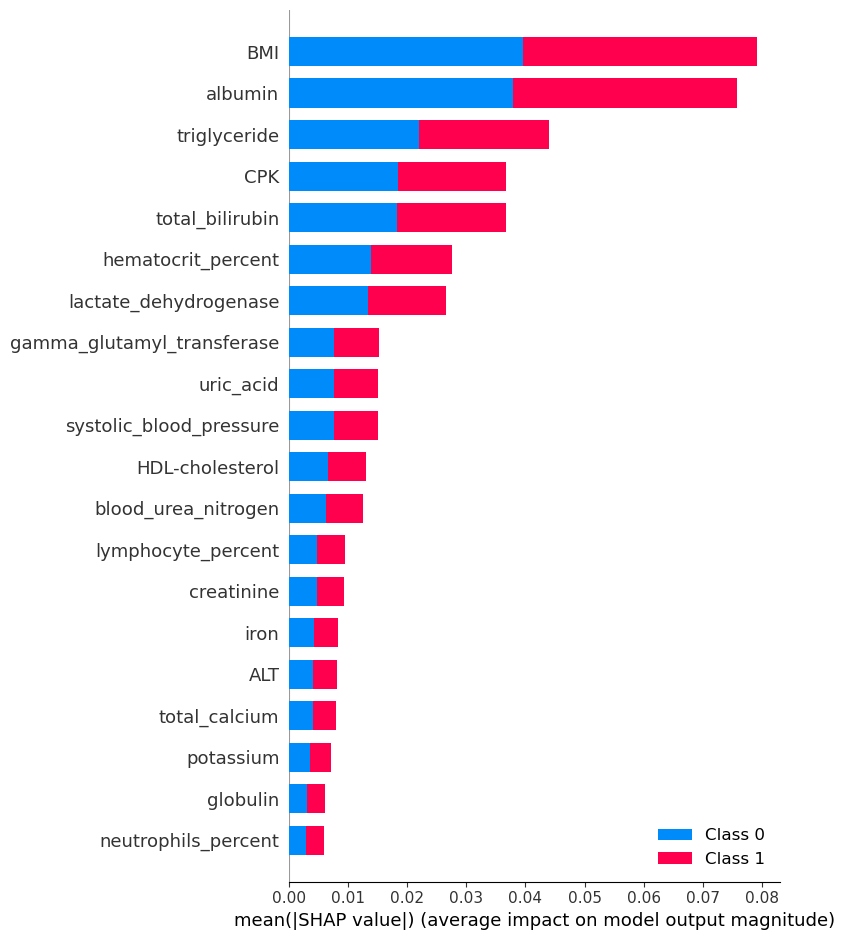

None

In [25]:
shap.initjs()
shap_explanation(rf_grid, X_test, start_index=108, end_index=109)

### LIME<a class="anchor" id="lime"></a>

Obtain local explanations for first 110 instances

In [26]:
lime_explanation(rf_grid, X_test, y_test, start_index=0, end_index=109)

<!-- http://127.0.0.1:7982/1942551963200/ -->